In [1]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.special import loggamma
from jax import vmap
from jax.scipy.special import j1
import mpmath as mp
jax.config.update("jax_enable_x64", True)

In [2]:
# Defining the relevant functions:

mp.mp.dps = 20  # increase if you push to very large |omega|
# 20 is roughly 64 bit precision I think

# confirmed: this works
def h_kernel(freqs, diameter, a):
    w = mp.mpf(freqs)
    iy2 = mp.mpc(0, w/2)
    pref = mp.power(mp.pi, -1j*w) * mp.power(diameter, 1 - 1j*w) / (2*mp.sqrt(2*mp.pi))

    # --- Term 1 ---
    # num1 = mp.gamma(mp.mpf('1.5') - iy2) * mp.gamma(1 + iy2)
    # den1 = mp.gamma(mp.mpf('1.5')) * mp.gamma(2 - iy2) * mp.gamma(3 - iy2)
    # log args
    num1 = mp.loggamma(mp.mpf('1.5') - iy2) + mp.loggamma(1 + iy2)
    den1 = mp.loggamma(mp.mpf('1.5')) + mp.loggamma(2 - iy2) + mp.loggamma(3 - iy2)

    hyp1 = mp.hyper([mp.mpf('0.5') - iy2, mp.mpf('1.5') - iy2],
                    [mp.mpf('1.5'), 2 - iy2, 3 - iy2],
                    -a*a)
    term1 = a * mp.exp(num1 - den1) * hyp1

    # --- Term 2 ---
    # num2 = mp.gamma(1 - iy2) * mp.gamma(mp.mpf('0.5') + iy2)
    # den2 = mp.gamma(mp.mpf('0.5')) * mp.gamma(mp.mpf('1.5') - iy2) * mp.gamma(mp.mpf('2.5') - iy2)
    # log args
    num2 = mp.loggamma(1 - iy2) + mp.loggamma(mp.mpf('0.5') + iy2)
    den2 = mp.loggamma(mp.mpf('0.5')) + mp.loggamma(mp.mpf('1.5') - iy2) + mp.loggamma(mp.mpf('2.5') - iy2)

    hyp2 = mp.hyper([1 - iy2, -iy2],
                    [mp.mpf('0.5'), mp.mpf('1.5') - iy2, mp.mpf('2.5') - iy2],
                    -a*a)
    term2 = mp.exp(num2 - den2) * hyp2

    return pref * (term1 + term2)


def polychrome_image_jax(x_coords, mellin_spec, h_hat, freqs):

    prefac = 1/(x_coords)# NO FACTOR OF sqrt2pi,,, cancels because unitary fourier transform convolution theorem * np.sqrt(2*np.pi))
    d_freq = freqs[1] - freqs[0]

    def single_poly(r):
        return np.sum(mellin_spec * h_hat * np.exp(-1.0j * freqs * np.log(r)) * d_freq)

    flat = vmap(single_poly)(x_coords.ravel())
    polychrome = flat.reshape(x_coords.shape) * prefac
    return polychrome

# Defining inverse mellin
def inverse_mellin(freqs, melweights, wavelengths):
    prefac = 1/np.sqrt(2*np.pi)

    d_freq = freqs[1] - freqs[0]

    inv_mellin = np.zeros_like(wavelengths, dtype=np.complex64)
    for idx, wl in enumerate(wavelengths):
        inv_mel = np.sum(melweights * wl **(-1j*freqs) * d_freq)
        inv_mellin = inv_mellin.at[idx].set(inv_mel)

    inv_mellin *= prefac
    return inv_mellin

# defining single wavelength airy disk, dispersion parameter alpha
def dispersedairydisk(x_coords, wavelength0, diameter, alpha):
    prefac = 1/wavelength0**2 * np.pi * diameter**2
    arg = np.pi * diameter* (x_coords/wavelength0 - alpha)
    airy = j1(arg)**2/arg**2
    airy *= prefac
    return airy

# defining the melin of a single wavelength (delta function)
def mellin_delta(freqs, wavelength0):
    prefac = 1/np.sqrt(2*np.pi)
    arg = wavelength0**(1j*freqs - 1)
    return prefac*arg

In [3]:
# defining the interval to look over:
diameter = 0.125
period = 200e-6
alpha = np.sqrt(2)/period

a = np.pi*diameter*alpha

# 6000 is more than enough
max_freq = 6000
# 1024.. this might take a while (10ish minutes)
N_freqs = 1024
freqs = np.linspace(-max_freq, max_freq, N_freqs)

h_kern = np.empty(len(freqs), dtype=np.complex128)
for i, w in enumerate(freqs):
    h_kern = h_kern.at[i].set(complex(h_kernel(float(w), float(diameter), float(a))))
    # update single-line status
    print(f"Completed {i+1}/{len(freqs)} — w={w:.6g}", end='\r', flush=True)

# finish with newline so prompt returns to next line
print()

Completed 1024/1024 — w=6000.27


In [4]:
wavelength = 585e-9

centre_rad = alpha*wavelength

radius_arcsec = 5
radius_rad = dlu.arcsec2rad(radius_arcsec)

N_coords = 256
x_coords = np.linspace(centre_rad - radius_rad, centre_rad + radius_rad, N_coords)

analytic_lsf = dispersedairydisk(x_coords, wavelength, diameter, alpha)

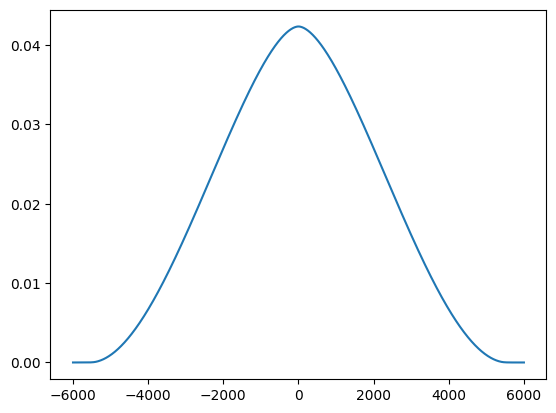

In [5]:
plt.plot(freqs, np.abs(h_kern))
plt.show()

In [7]:
melspec = mellin_delta(freqs, wavelength)

lsf_mellin = polychrome_image_jax(x_coords, melspec, h_kern, freqs)

# i can't really believe that this actually works. wtf!!

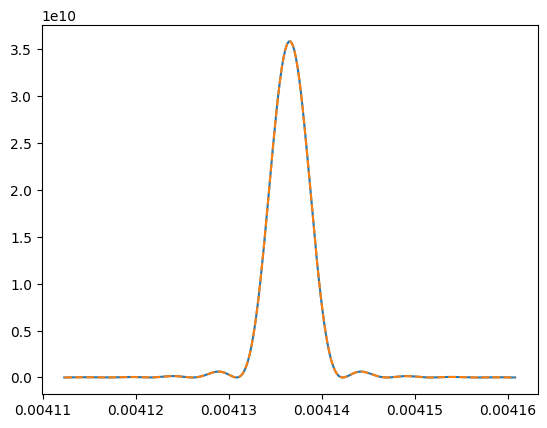

In [10]:
plt.plot(x_coords, analytic_lsf)
plt.plot(x_coords, np.real(lsf_mellin), linestyle='--')
plt.show()

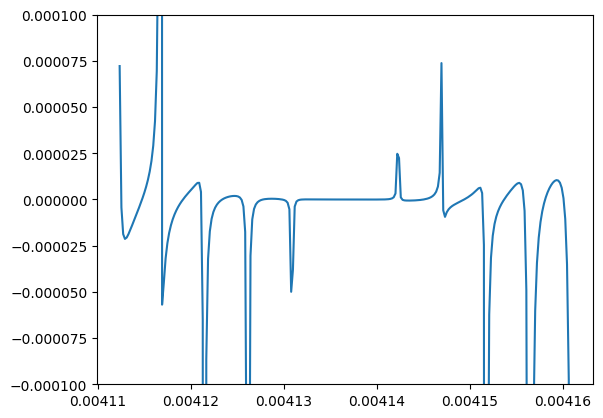

In [12]:
plt.plot(x_coords,(np.real(lsf_mellin)-analytic_lsf)/analytic_lsf)
plt.ylim(-0.0001,0.0001)
plt.show()

In [130]:
import optax
from jax import jit, value_and_grad

rad_to_pix = x_coords[1] - x_coords[0]

flux = 1e10

# --- model / forward -------------------------------------------------------
@jit
def polychrome_image_jax(x_coords, mellin_spec, h_hat, freqs):
    # r_coords: (H,W) or (N,)
    d_freq = freqs[1] - freqs[0]
    flat_x = x_coords.ravel()
    log_x = np.log(flat_x)               # ensure r>0 (avoid r=0)
    phasors = np.exp(-1.0j * np.outer(log_x, freqs))   # (N, F)
    contrib = (mellin_spec * h_hat * d_freq)             # (F,)
    flat = phasors @ contrib                             # (N,) complex
    polychrome = flat.reshape(x_coords.shape) / x_coords
    # convert to pixels
    polychrome *= rad_to_pix**2
    # add flux
    polychrome *= flux
    return np.maximum(np.real(polychrome),1e-12)

model_lsf = polychrome_image_jax(x_coords, melspec, h_kern, freqs)

In [ ]:
import jax
from jax import jit
from jax.flatten_util import ravel_pytree
import jax.scipy as jsp

def model_from_params(params, x_coords, freqs):
    # Example: rebuild mellin_spec from params if you store it split into real+imag
    mellin_spec = params['mag'] * np.exp(1j*np.angle(melspec))
    # call your existing forward function (which returns real-valued mu)

    mu = polychrome_image_jax(x_coords, mellin_spec, h_kern, freqs)

    return mu  

# --- Poisson log-likelihood (sum over pixels) -------------------------------
# y: observed integer counts, same shape as mu
def poisson_loglik(params, x_coords, freqs, y):
    mu = model_from_params(params, x_coords, freqs)      # predicted means
    ll = np.sum(y * np.log(mu) - mu)
    return ll

# Gaussian loglikelihood. Just minimise the squares
def gauss_loglik(params, x_coords, freqs, y):
    mu = model_from_params(params, x_coords, freqs)

    ll = np.sum(-(mu-y)**2)
    return ll

# --- Flatten params to a vector so Hessian is a (P,P) array -----------------
# given an example initial params pytree `params0`
# how do I do this part?
params0 = {
    'mag': np.asarray(np.abs(np.asarray(melspec))),   # use your initial melspec
}

flat_params0, unravel_fn = ravel_pytree(params0)   # flat_params0 is a jnp vector

# scalar function taking flat vector -> scalar loglik
def scalar_loglik_flat(flat_x, y):
    params = unravel_fn(flat_x)
    return poisson_loglik(params, x_coords, freqs, y)
    #return gauss_loglik(params, x_coords, freqs, y)

observed_fisher = - jax.jit(jax.hessian(scalar_loglik_flat))(flat_params0, model_lsf)

In [ ]:
def inverse_nu_integral(x_coords, wavelength, diameter, alpha):
    d_x = x_coords[1] - x_coords[0]

    inuint = np.sum(1/(x_coords*dispersedairydisk(x_coords, wavelength, diameter, alpha)) * d_x)

    return inuint

fisher_info = np.abs(h_kern)**2 * flux * inverse_nu_integral(x_coords, wavelength, diameter, alpha)

d_freq = freqs[1]-freqs[0]
# ehhh doesn't really work.

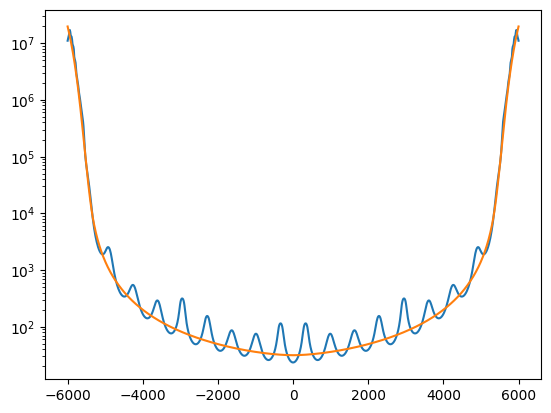

In [ ]:
#plt.plot(freqs, 1/np.sqrt(np.diag(observed_fisher)))
plt.plot(freqs, np.convolve(1/np.sqrt(np.diag(observed_fisher)), np.ones(11)/(11), mode='same'))

#plt.plot(freqs, cov_diag)
plt.plot(freqs, 2e2/np.sqrt(fisher_info * d_freq**2))
plt.yscale('log')
#plt.ylim(0,1e5)
plt.show()
# and it fits exactly.
# there are some factors that are going whack... but don't matter particularly much. 